# 2018-11-21 A  ring with topology
Youpi on impose la sparseness et ça marche, avec ou sans synapses, maintenant on va utiliser les coordonnées des filtres pour donner des probabilités de connexion localisation dépendantes, ce qui nous permettra de jouer sur la topologie chat/souris.

# Ce notebook est expérimental AF :
http://neuralensemble.org/docs/PyNN/reference/populations.html

http://neuralensemble.org/docs/PyNN/space.html

http://neuralensemble.org/docs/PyNN/connections.html

http://neuralensemble.org/docs/PyNN/_modules/pyNN/space.html#Grid2D

# TODO : Assertion error bugfix, where is it coming from ?

# Tests des formes des distances

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(1/np.exp(np.arange(10)), label = '1/exp')
plt.plot(1 + -.1*np.arange(10), label = 'Linear -10%')
plt.plot(1 + -.05*np.arange(10), label = 'Linear 5%')
plt.legend()

# On regénère les centroïdes pour les utiliser en topologie ensuite

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
import Spiking_LGN as SpiLGN
import datetime
from tqdm import tqdm

import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

/home/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
import Spiking_LGN as SpiLGN
import datetime
from tqdm import tqdm

import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

video = np.load('./MotionClouds_64x64x128_24FPS.npy')
print(video.shape)

output_currents = SpiLGN.input_to_currents(video=video, FPS=24., total_time=1000,
                                           distrib_size=8, safeguard_offset=5, random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=10)
load_arr = np.asarray(output_currents) #ça evite de réécrire tout le code

(64, 64, 128)
Video shape (64, 64, 128)
Frames per second: 24.0
Frame duration at 24.0 FPS: 41.67 ms
Video length inferred from fps: 6 s
FPS conversion sanity check passed !

Stimuli shape (64, 64, 1000)

Generating filters coordinates with gabors ..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  9.9min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 14.6min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 14.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Done ! Generating currents from filters ..


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 10.0min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 15.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 15.5min finished


Text(0.5,1,"Distribution des champs récepteurs dans l'image")

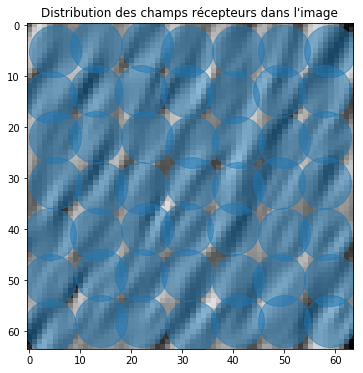

In [4]:
coor = SpiLGN.generate_centers_coordinates(
        distrib_size=8, safeguard_offset = 5, random_shift = 1, video=video)

colors = plt.cm.winter(np.linspace(.3, 1,12))

fig = plt.figure(figsize = (8,6))
plt.scatter(coor[0],
            coor[1],
            s = 52**2, alpha = .5)

plt.imshow(video[:,:,0], cmap = plt.cm.binary)
plt.title("Distribution des champs récepteurs dans l'image")

In [5]:
import numpy as np

def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(r, theta)

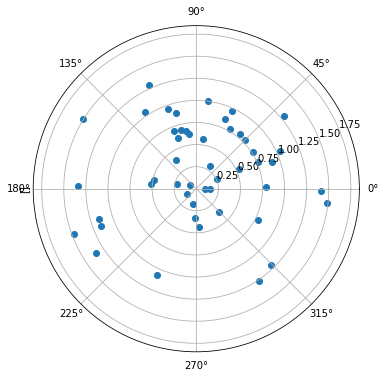

In [6]:
(xpol, ypol) = cart2pol(coor[0], coor[1])

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='polar')
ax.set_ylabel([])
ax.scatter(xpol, ypol)

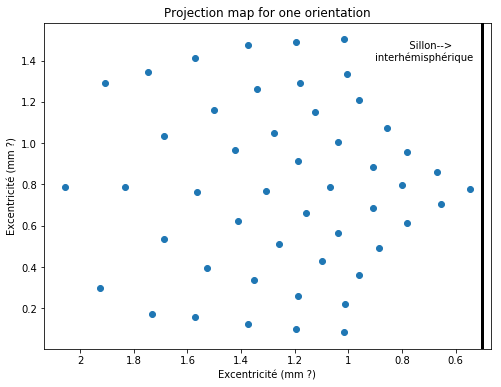

In [7]:
(xpol, ypol) = cart2pol(coor[0], coor[1])

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.scatter(xpol, ypol)

ax.set_xticklabels([0,2, 1.8, 1.6, 1.4, 1.2, 1, 0.8, .6])
ax.axvline(85, color = 'black', linewidth = 3)
ax.text(65, 1.4, '           Sillon-->\ninterhémisphérique')
ax.set_xlabel('Excentricité (mm ?)')
ax.set_ylabel('Excentricité (mm ?)')
plt.title('Projection map for one orientation')
#plt.savefig('./figs/2018_11_21_Polar_projection_confused.pdf', format= 'pdf', dpi = 200)
plt.show()

# Generating space for the neurons 

In [44]:
#pyNN topology is retarded, let's define our own class
class TimeWarpGrid(sim.space.BaseStructure):
    '''
    Returns a 3xn shaped numpy array. Xpol and Ypol are logpolar coordinates for each of the centroids
    of a single orientation. N, the total number of neuron, is fed by the pyNN generator, and the 
    generate_positions functions tiles the arrays to repeat the 49 positions for each orientation.
    
    This means that the structure works IF AND ONLY IF we iterate through orientations when injecting
    currents.
    '''
    parameter_names = ("xpol", "ypol")

    def __init__(self, xpol, ypol):
        self.xpol = xpol
        self.ypol = ypol

    def generate_positions(self, n):
        nbr_orientations = 12 #number of orientations repeats
        pos = np.array([ np.tile(np.asarray(self.xpol), nbr_orientations),
                         np.tile(np.asarray(self.ypol), nbr_orientations),
                         np.tile(np.zeros(len(self.xpol)), nbr_orientations) 
                       ])
        return pos
        # must return a 3xn numpy array

In [55]:
k = TimeWarpGrid(xpol, ypol).generate_positions(total_neurons) #n is a dummy variable
k[0].shape

(588,)

# Simulation time

In [56]:
##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

syn_params = {'sparseness' : .05, # U.Arb.
             'w' : .01, # siemens ?,
             'delay' : 2. #ms
             }
gain = .05
injection_sampling_rate = 1
total_time = 1000

total_neurons = load_arr.shape[0] * load_arr.shape[1]

current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [57]:
#############
# Simulation#
#############
sim.setup(timestep=0.1)

simple_cells = sim.Population(total_neurons, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="simple_cells",
                             structure = TimeWarpGrid(xpol, ypol))

exc_exc_connexion = sim.Projection(simple_cells, simple_cells,
                                sim.DistanceDependentProbabilityConnector("1/exp(d)"), 
                                sim.StaticSynapse(weight=syn_params['w'], 
                                                  delay=syn_params['delay'])
                                )

neuron_iterator = 0

with tqdm(total = total_neurons, desc = 'LGN is communicating with V1') as progress_bar :
    for orientations in load_arr:
        for positions in orientations :
            #injecting all ON LGN current
            for inputs in positions[0]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #injecting all OFF LGN current
            for inputs in positions[1]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #moving on to next V1 neuron 
            neuron_iterator +=1
            progress_bar.update(1)
            
simple_cells.record(['spikes', 'v'])
sim.run(total_time)
sim.end()

/home/hugo/anaconda3/lib/python3.6/site-packages/lazyarray.py:548: RuntimeWarning: overflow encountered in exp
  return func(x)


AssertionError: 

In [ ]:
v1_data = simple_cells.get_data().segments[0]
v1_voltage = v1_data.analogsignals[0]

In [ ]:
#NEO's arrays are weirdly shaped, we have to transpose them
fig, ax = plt.subplots(figsize = (16,10))
colors = plt.cm.autumn(np.linspace(.1, 1, 49))

neuron_iterator = 0
orientation = 3

for positions in load_arr[orientation]:
    index = neuron_iterator + (orientation * load_arr.shape[0]) #we're skipping the other positions

    ax.plot(v1_voltage.T[index],
            color=colors[neuron_iterator],
            alpha = 1)
        
    for spikes in np.asarray(v1_data.spiketrains[index]):
        plt.plot([ spikes*10,spikes*10 ] , [v1_voltage.T[index][int(spikes)] , 20],
        color=colors[neuron_iterator])

    neuron_iterator +=1


plt.title("Spikes for neurons preferring theta = %s" % ((np.pi/12)*3*180/np.pi))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Blues(np.linspace(.4, 1, 12))

neuron_iterator = 0
total_spikes, total_spiking_neurons = 0, 0


for i,orientations in enumerate(load_arr):
    for positions in orientations:
        ax.scatter(v1_data.spiketrains[neuron_iterator],
                   np.full_like(v1_data.spiketrains[neuron_iterator], neuron_iterator),
                   s=5, color=colors[i],
                   label='%.1f°' % (i*(np.pi/12)*180/np.pi) if neuron_iterator%25 ==0 else '')
        
        total_spikes += len(v1_data.spiketrains[neuron_iterator])
        if len(v1_data.spiketrains[neuron_iterator]) > 0:
            total_spiking_neurons += 1
            
        neuron_iterator += 1

plt.ylim(-5, total_neurons)
plt.xlim(150, total_time)

plt.ylabel('Neuron index')
plt.xlabel('Time (ms)')
handles, labels = ax.get_legend_handles_labels()
#handles[::-1], labels[::-1],
plt.legend(markerscale=3, title='Preferred orientation\n    for one position',
           ncol=2)

plt.title('''
            Mean population FR : %.2f Hz''' % (total_spikes/total_spiking_neurons))

#plt.savefig('./figs/2018_11_16_Ring_spikes_nosynapses_orientation.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

In [ ]:
#firing rates for all neurons, excluding the initialisation artifact
fr_list = []
for neuron_fr in v1_data.spiketrains :
    fr_list.append(len(np.where(neuron_fr>150)[0]))
    
len(fr_list)

In [ ]:
# We split for each orientation
k = np.split(np.asarray(fr_list), 12)
k

In [ ]:
#wrong axis ?? ask laurent
plt.plot(np.mean(k, axis = 0))

In [ ]:
#that seems more like it
plt.plot(np.mean(k, axis = 1))
plt.xlabel('Thetas')
plt.ylabel('Mean FR')

In [ ]:
from lmfit.models import GaussianModel

x = np.linspace(0, 6,6)
y = np.asarray(np.mean(k, axis = 1)[:6])

mod = GaussianModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.25))

def fit_curve(xs, sigma, center, amplitude):
    return amplitude/(sigma *np.sqrt(2*np.pi)) * np.exp( (-(xs-center)**2)/ (2*sigma**2)) 

gaussian_distrib1 = fit_curve(xs=np.linspace(0, 6, 100),
                             sigma=out.best_values['sigma'],
                             center=out.best_values['center'],
                             amplitude=out.best_values['amplitude'])

#####################################################################################################
x = np.linspace(7, 12,6)
y = np.asarray(np.mean(k, axis = 1)[6:])

mod = GaussianModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.25))

def fit_curve(xs, sigma, center, amplitude):
    return amplitude/(sigma *np.sqrt(2*np.pi)) * np.exp( (-(xs-center)**2)/ (2*sigma**2)) 

gaussian_distrib2 = fit_curve(xs=np.linspace(6, 12, 100),
                             sigma=out.best_values['sigma'],
                             center=out.best_values['center'],
                             amplitude=out.best_values['amplitude'])

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(np.mean(k, axis = 1), '.b')
plt.plot(np.linspace(0,6,100),gaussian_distrib1, color = 'black')
plt.plot(np.linspace(6,12,100),gaussian_distrib2, color = 'black')


plt.title('Mean firing rate for each orientation, described by two gaussians\nGround truth = 4')

plt.xlabel('Orientation (theta)')
plt.ylabel('Meaniring rate (Hz)')
#plt.savefig('./figs/2018_11_22_Orientation_curves.pdf', dpi = 200, format = 'pdf', bbox_inches = 'tight')
plt.show()